### Inpainting

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from nnf import NNF

In [2]:
class InpaintNNF:
    """
    Class for inpainting an image using the PatchMatch algorithm.
    Follows downsample-then-upsample approach.
    """
    def __init__(self, image, mask, patch_w=7, max_pm_iters=5):
        """
        image: numpy array of shape (height, width, 3)
        mask: numpy array of shape (height, width)
        """
        # ensure size of image and mask are the same
        assert image.shape[1] == mask.shape[1] and image.shape[0] == mask.shape[0]
        self.image = image
        self.mask = mask
        self.patch_w = patch_w
        self.max_pm_iters = max_pm_iters
        self.pyramid = [] # list to store the downsampled images and masks
        
        self._build_pyramid()
        
    
    def _build_pyramid(self):
        """
        Build the image pyramid.
        """
        self.pyramid.append((self.image, self.mask))
        img = self.image.copy()
        mask = self.mask.copy()
        stopping_patch_size = self.patch_w * 3
        while img.shape[0] > stopping_patch_size and img.shape[1] > stopping_patch_size:
            img = self._downsample_img(img, 2)
            mask = self._downsample_mask(mask, 2)
            self.pyramid.append((img, mask))
        
        
    def _downsample_img(self, img, factor):
        return cv2.resize(img, (img.shape[1]//factor, img.shape[0]//factor))
    
    def _upsample_img(self, img, src_size):
        height, width, _ = src_size
        return cv2.resize(img.astype(np.uint8), (width, height)).astype(np.int32)
    
    def _downsample_mask(self, mask, factor):
        mask = cv2.resize(mask, (mask.shape[1]//factor, mask.shape[0]//factor))
        mask = np.where(mask > 0.5, 1, 0).astype(np.uint8)
        return mask
    
    def _get_patch_similarity(self, nnf_object, ax, ay, bx, by):
        """
        Get the similarity between two patches.
        """
        patch_dist = nnf_object.patch_distance(ax, ay, bx, by)
        return 1 - patch_dist/nnf_object.MAX_PATCH_DIFF
    
    def weighted_copy(self, src, mask, ax, ay, bx, by, w):
        """
        Copy the patch from src to target with weight w.
        """

        votes = np.zeros((src.shape[0], src.shape[1], 4))

        if mask[ay, ax] == 0:
            return votes
        
        votes[by, bx, 0] += src[ay, ax, 0] * w
        votes[by, bx, 1] += src[ay, ax, 1] * w
        votes[by, bx, 2] += src[ay, ax, 2] * w
        votes[by, bx, 3] += w

        return votes

    def e_step(self, nnf_obj, new_src=None, new_mask=None, upscale=False):
        """
        E-step of the EM algorithm.
        """
        votes = np.zeros((new_src.shape[0], new_src.shape[1], 4))
        for ay in range(nnf_obj.aeh):
            for ax in range(nnf_obj.aew):
                
                # print("E-step: ", ay, ax)
                bx, by = nnf_obj.nnf[ay, ax]
                # print("bx, by: ", bx, by)
                w = self._get_patch_similarity(nnf_obj, ax, ay, bx, by)

                if upscale:
                    votes += self.weighted_copy(new_src, new_mask, 2*ax, 2*ay, 2*bx, 2*by, w)
                    votes += self.weighted_copy(new_src, new_mask, 2*ax+1, 2*ay, 2*bx+1, 2*by, w)
                    votes += self.weighted_copy(new_src, new_mask, 2*ax, 2*ay+1, 2*bx, 2*by+1, w)
                    votes += self.weighted_copy(new_src, new_mask, 2*ax+1, 2*ay+1, 2*bx+1, 2*by+1, w)

                else:
                    votes += self.weighted_copy(new_src, new_mask, ax, ay, bx, by, w)

        return votes
    
    def m_step(self, new_target, votes):
        """
        M-step of the EM algorithm.
        """
        new_target = new_target.copy()
        for by in range(new_target.shape[0]):
            for bx in range(new_target.shape[1]):
                if votes[by, bx, 3] > 0:
                    new_target[by, bx, 0] = votes[by, bx, 0] / votes[by, bx, 3]
                    new_target[by, bx, 1] = votes[by, bx, 1] / votes[by, bx, 3]
                    new_target[by, bx, 2] = votes[by, bx, 2] / votes[by, bx, 3]
        return new_target


    def expectation_maximization(self, nnf_src_to_target_obj, nnf_target_to_src_obj, level, is_last_iter=False):
        """
        src: numpy array of shape (height, width, 3)
        target: numpy array of shape (height, width, 3)
        """
        # compute the nnfs
        nnf_src_to_target, nnf_src_to_target_dist = nnf_src_to_target_obj.compute_nnf()
        nnf_target_to_src, nnf_target_to_src_dist = nnf_target_to_src_obj.compute_nnf()
        
        upscaled = False

        # last iter of the em loop
        if is_last_iter:
            new_src = self.pyramid[level-1][0]
            new_mask = self.pyramid[level-1][1]
            new_target = self._upsample_img(nnf_src_to_target_obj.b.copy(), new_src.shape)
            upscaled = True

        else:
            new_src = self.pyramid[level][0]
            new_mask = self.pyramid[level][1]
            new_target = nnf_src_to_target_obj.b.copy()


        # E-step
        votes1 = self.e_step(nnf_src_to_target_obj, new_src, new_mask, upscale=upscaled)
        votes2 = self.e_step(nnf_target_to_src_obj, new_src, new_mask, upscale=upscaled)
        votes = votes1 + votes2

        # M-step
        new_target = self.m_step(new_target, votes)

        return new_target, nnf_src_to_target, nnf_target_to_src
        
    def inpaint(self):

        inpainted_images = []

        num_pyramid_levels = len(self.pyramid)
        inpainted_img = None
        running_nnf_src_to_target = None
        running_nnf_target_to_src = None
        for level in range(num_pyramid_levels-1, 0, -1):
            
            iterEM = 1+2*level
            iterNNF = min(7,1+level)
            src, mask = self.pyramid[level]
            no_mask = np.ones_like(mask)
            # src_with_mask = src.copy() * np.stack([mask]*3, axis=2)
            print("Level: ", level)
            print("EM iters: ", iterEM)
            print("Src size: ", src.shape)
            
            # smallest level
            if level == num_pyramid_levels-1:
                inpainted_img = src.copy()
                
                # initialize the nnfs with masks for both directions
                nnf_src_to_target_obj = NNF(src, inpainted_img, mask_a=mask, mask_b=no_mask, patch_w=self.patch_w, pm_iters=iterNNF)
                nnf_src_to_target_obj.initialize_nnf_with_mask(mask)
            
                nnf_target_to_src_obj = NNF(inpainted_img, src, mask_a=no_mask, mask_b=mask, patch_w=self.patch_w, pm_iters=iterNNF)
                nnf_target_to_src_obj.initialize_nnf_with_mask(mask)
            else:
                # initialize the nnfs with masks for both directions
                nnf_src_to_target_obj = NNF(src, inpainted_img, mask_a=mask, mask_b=no_mask, patch_w=self.patch_w, pm_iters=iterNNF)
                nnf_src_to_target_obj.initialize_nnf_with_other_nnf(running_nnf_src_to_target)
                nnf_src_to_target_obj.initialize_nnf_with_mask(mask)
            
                nnf_target_to_src_obj = NNF(inpainted_img, src, mask_a=no_mask, mask_b=mask, patch_w=self.patch_w, pm_iters=iterNNF)
                nnf_target_to_src_obj.initialize_nnf_with_other_nnf(running_nnf_target_to_src)
                nnf_target_to_src_obj.initialize_nnf_with_mask(mask)
            
            # run the EM algorithm multiple times
            for em_step in range(iterEM):
                
                # EM
                inpainted_img, running_nnf_src_to_target, running_nnf_target_to_src = self.expectation_maximization(
                    nnf_src_to_target_obj, nnf_target_to_src_obj, level, is_last_iter=(em_step == iterEM-1))
                
                nnf_src_to_target_obj.b = inpainted_img.copy()
                nnf_target_to_src_obj.a = inpainted_img.copy()     
                # nnf_src_to_target_obj._set_height_width()
                # nnf_target_to_src_obj._set_height_width()
                # plt.imshow(inpainted_img)
                # plt.show()
            
            # upsample the inpainted image if not the last level
            # if level > 0:
            #     inpainted_img = self._upsample_img(inpainted_img, self.pyramid[level-1][0].shape)

            inpainted_images.append(inpainted_img.astype(np.uint8))

            print("Level: ", level, " done.")
            
        return inpainted_img, inpainted_images

        

In [ ]:
src_img = cv2.imread("../images/football_sky.jpg")
mask = cv2.imread("../images/football_sky_mask.jpg", cv2.IMREAD_GRAYSCALE)
mask = np.where(mask > 127, 1, 0).astype(np.uint8)

inpainter = InpaintNNF(src_img, mask, patch_w=7, max_pm_iters=5)
inpainted_img, inpainted_images = inpainter.inpaint()

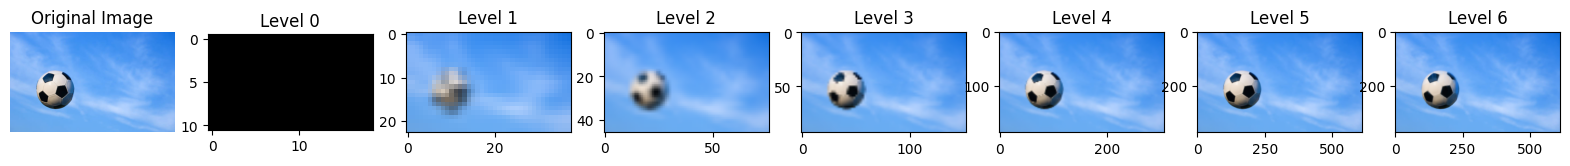

In [5]:
length = len(inpainted_images)
plt.figure(figsize=(20, 20))
plt.subplot(1, length+1, 1)
plt.imshow(cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")
for i in range(length):
    plt.subplot(1, length+1, i+2)
    plt.imshow(cv2.cvtColor(inpainted_images[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Level {i}")
    # plt.axis("off")
plt.show()

In [40]:
src_img = cv2.imread("../images/forest.png")
mask = cv2.imread("../images/forest_mask.png", cv2.IMREAD_GRAYSCALE)
mask = np.where(mask > 127, 0, 1).astype(np.uint8)

inpainter = InpaintNNF(src_img, mask, patch_w=7, max_pm_iters=5)
inpainted_img, inpainted_images = inpainter.inpaint()

Level:  5
Level:  4
Level:  3
Level:  2
Level:  1


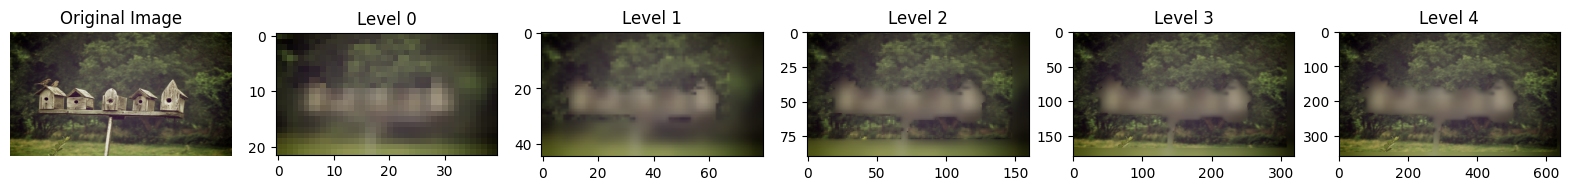

In [42]:
length = len(inpainted_images)
plt.figure(figsize=(20, 20))
plt.subplot(1, length+1, 1)
plt.imshow(cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")
for i in range(length):
    plt.subplot(1, length+1, i+2)
    plt.imshow(cv2.cvtColor(inpainted_images[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Level {i}")
    # plt.axis("off")
plt.show()

In [ ]:
src_img = cv2.imread("../images/bridge.jpg")
mask = cv2.imread("../images/bridge_mask.png", cv2.IMREAD_GRAYSCALE)
# mask = np.where(mask > 127, 0, 1).astype(np.uint8)

inpainter = InpaintNNF(src_img, mask, patch_w=15, max_pm_iters=5)
inpainted_img, inpainted_images = inpainter.inpaint()

(461, 640)
(461, 640, 3)


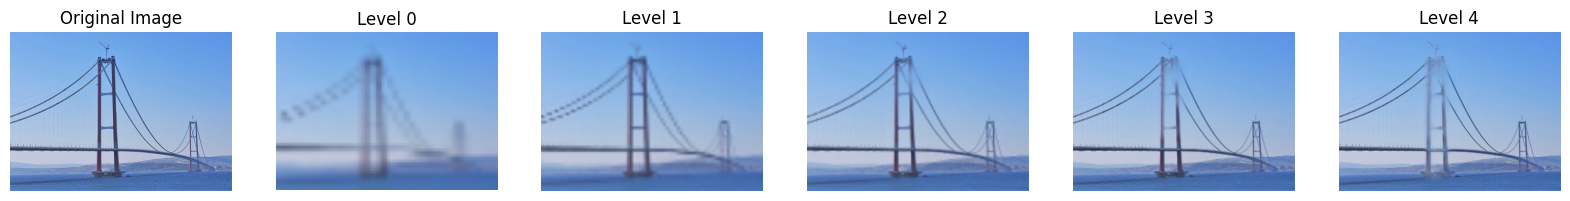

In [33]:
length = len(inpainted_images)
plt.figure(figsize=(20, 20))
plt.subplot(1, length+1, 1)
plt.imshow(cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")
for i in range(length):
    plt.subplot(1, length+1, i+2)
    plt.imshow(cv2.cvtColor(inpainted_images[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Level {i}")
    plt.axis("off")
plt.show()

In [3]:
src_img = cv2.imread("../images/green.jpg")
mask = cv2.imread("../images/green_mask.png", cv2.IMREAD_GRAYSCALE)
mask = np.where(mask > 127, 1, 0).astype(np.uint8)

inpainter = InpaintNNF(src_img, mask, patch_w=7, max_pm_iters=5)
inpainted_img, inpainted_images = inpainter.inpaint()

Level:  3
EM iters:  7
Src size:  (12, 12, 3)
Level:  3  done.
Level:  2
EM iters:  5
Src size:  (25, 25, 3)
Level:  2  done.
Level:  1
EM iters:  3
Src size:  (50, 50, 3)
Level:  1  done.


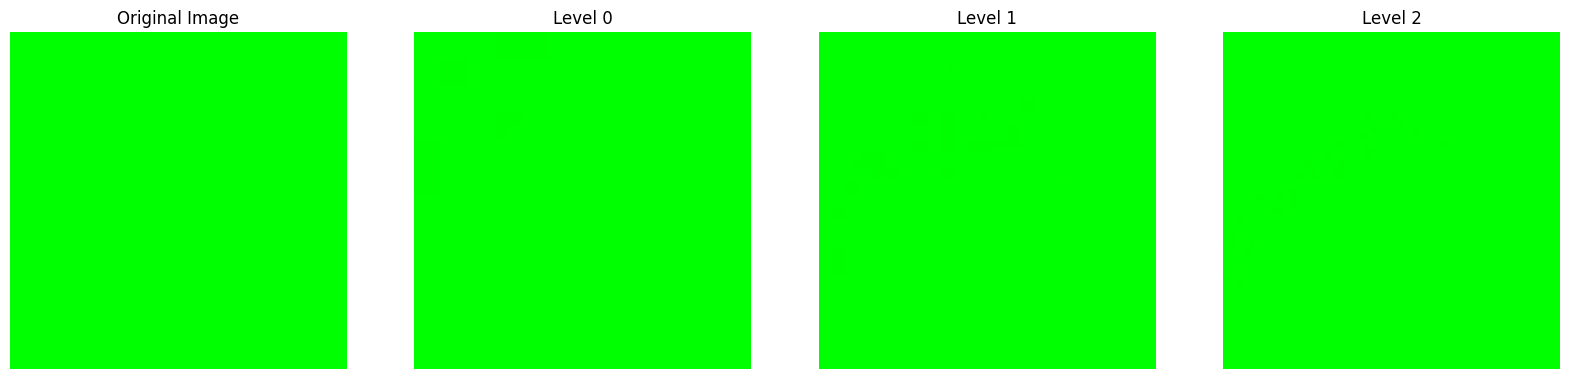

In [4]:
length = len(inpainted_images)
plt.figure(figsize=(20, 20))
plt.subplot(1, length+1, 1)
plt.imshow(cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")
for i in range(length):
    plt.subplot(1, length+1, i+2)
    plt.imshow(cv2.cvtColor(inpainted_images[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Level {i}")
    plt.axis("off")
plt.show()